# Creating dataset

# Creating classification model

In [1]:
import os
import pickle
import numpy as np
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import keras
import shutil
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

Using TensorFlow backend.


In [2]:
DATASET_PATH = '../../datasets/Classification/Dataset - 3 dias/'
CATEGORIES = ["Normal", "Anormal", "Morta"]

##### Read dataset

In [3]:
IMG_SIZE = 256
NUM_CLASSES = 2
def read_dataset():
    images_raw = open(os.path.join(DATASET_PATH, "3_days_images.pickle" ), "rb")
    images = pickle.load(images_raw)

    labels_raw = open(os.path.join(DATASET_PATH, "3_days_labels.pickle" ), "rb")
    labels = pickle.load(labels_raw)

    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

###### Turn it into a binary classification problem

In [4]:
def to_binary(labels):
    labels[labels == 2] = 1
    return labels
    

###### Train Test split

In [5]:
def count_samples(train_labels, test_labels):
    print("In training:")
    for i in range(0,NUM_CLASSES):
        print(f'Class {i}: {round(100 * np.count_nonzero(np.array(train_labels) == i) / len(train_labels), 2)}%')
    print("In test:")
    for i in range(0,NUM_CLASSES):
        print(f'Class {i}: {round(100 * np.count_nonzero(np.array(test_labels) == i) / len(test_labels), 2)}%')


def train_test_split(images, labels):

    from sklearn.model_selection import train_test_split

    train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.1, stratify=labels)
    
    print("In training:")
    for i in range(0,len(np.unique(labels))):
        print(f'Class {i}: {round(100 * np.count_nonzero(np.array(train_labels) == i) / len(train_labels), 2)}%')
    print("In test:")
    for i in range(0,len(np.unique(labels))):
        print(f'Class {i}: {round(100 * np.count_nonzero(np.array(test_labels) == i) / len(test_labels), 2)}%')
        
    return train_images, test_images, train_labels, test_labels

#### Ajustando o dataset desbalanceado

###### Data augmentation -> data generator

In [6]:
# data augmentation with ImageDataGenerator -> did not go well
# from keras.preprocessing.image import ImageDataGenerator
# datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=False,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.25
# )
# datagen.fit(train_images)

# # it = datagen.flow(train_images, batch_size=1, save_to_dir="test", shuffle= True)

# # # generate samples and plot
# # for i in range(50):
# #      # generate batch of images
# #     batch = it.next()
# #     # convert to unsigned integers for viewing
# #     image = batch[0].astype('uint8')
# #     # plot raw pixel data
# #     plt.imshow(image, cmap="gray")
# #     plt.show()
# # show the figure

###### Weighted Classes 

In [7]:
# Trying class weights
# it does not work with one hot encoded data
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(train_labels),
#                                                  train_labels)

def get_sample_weights(train_labels):
    from sklearn.utils import compute_sample_weight
    
    return compute_sample_weight('balanced', train_labels)  #->>>> remember to add the weights in model.fit

###### SMOTE

In [8]:
# classes, counts = np.unique(train_labels, return_counts=True)
# print(f"The number of elements for each class in training now are\nClass 0: {counts[0]}\nClass 1 {counts[1]}\nClass 2 {counts[2]}\n")

In [9]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=42)

# train_images_shape = train_images.shape
# train_images = train_images.reshape((train_images_shape[0], IMG_SIZE * IMG_SIZE * 3))
# train_images, train_labels = sm.fit_resample(train_images, train_labels)


In [10]:
# train_images_shape = train_images.shape
# train_images = train_images.reshape((train_images_shape[0], IMG_SIZE, IMG_SIZE, 3))


In [11]:
# classes, counts = np.unique(train_labels, return_counts=True)
# print(f"The number of elements for each class in training now are\nClass 0: {counts[0]}\nClass 1 {counts[1]}\nClass 2 {counts[2]}\n")

##### One hot label encoding

In [12]:
def to_one_hot(data):
    import pandas as pd
    data = pd.get_dummies(data)
    data = pd.DataFrame.to_numpy(data)
    return data

##### Normalizing training images

In [13]:
def normalize_images(data):
    data = tf.keras.utils.normalize(data, axis=0, order=2)
    return data

### Creating the model


In [14]:
EPOCHS = None
TRAIN_TEST_SPLIT = None
BATCH_SIZE = None
# print((1 - TRAIN_TEST_SPLIT) * train_images.shape[0],BATCH_SIZE)

METRICDIR = '../metricas/classificacao/7_d/tests-binary'

MODELDIR = os.path.join(METRICDIR, "adhoc")

CHECKPOINT_DIR = os.path.join(MODELDIR, "models") 

if os.path.exists(MODELDIR):
    shutil.rmtree(MODELDIR)
    os.makedirs(CHECKPOINT_DIR)
    
my_metrics = ["accuracy",
       tf.keras.metrics.Precision(),
       tf.keras.metrics.Recall(),
       tf.keras.metrics.AUC(),
       tf.keras.metrics.TruePositives(),
       tf.keras.metrics.TrueNegatives(),
       tf.keras.metrics.FalsePositives(),
       tf.keras.metrics.FalseNegatives(),]

In [15]:
def create_model():
       
    model = Sequential()

    model.add(   Conv2D(8, (3,3), input_shape=(IMG_SIZE,IMG_SIZE, 3))  )
    model.add(Dropout(rate=0.3))
    model.add(Activation("relu"))

    model.add(Conv2D(6, (3,3)))
    model.add(Dropout(rate=0.3))
    model.add(Activation("relu"))
    
    model.add(Conv2D(2, (3,3)))
    model.add(Dropout(rate=0.4))
    model.add(Activation("relu"))
    
    model.add(Flatten())
    model.add(Dense(1))
    
    model.add(Activation("sigmoid"))
    
    opt = tf.keras.optimizers.Adam()
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=my_metrics)
    
    return model

def get_model_name(k):
    return 'model_'+str(k)

def plot_metric(history,metric_name, chart_name, save_dir, save = False, show = False):
    plt.cla() 
    plt.plot(history.history[metric_name], label = metric_name + ' (training data)')
    plt.plot(history.history['val_' + metric_name], label = metric_name + ' (validation data)')
    plt.title(chart_name)
    plt.ylabel( metric_name + ' value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    if save:
        plt.savefig(os.path.join(save_dir, metric_name))
    if show:
        plt.show()
        
def plot_cm(cf_matrix, save_dir, save):
    
    import seaborn as sns; sns.set_theme()
   
    group_names = ['True Pos','False Pos','False Neg','True Neg']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    plt.cla() 
    
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    if save:
        plt.savefig(os.path.join(save_dir, "confusion matrix"))
    plt.show()

##### Testing the model

In [16]:
def one_hot_to_1d(test_labels):
    
    test_labels_1d = []
    
    for label in test_labels:
        print()
        if (label == [1, 0]).all():
            test_labels_1d.append(0)
        elif (label == [0, 1]).all():
            test_labels_1d.append(1)
        else:
            test_labels_1d.append(2)
    
    return test_labels_1d
    
def get_predictions(model,test_images, test_labels):
    prediction = model.predict(test_images, batch_size=1)

    return tf.argmax(prediction, axis=-1)

In [17]:
def train_models(train_images, train_labels, num_folds=10):
    
    from sklearn.model_selection import StratifiedKFold
    
    kfold = StratifiedKFold(n_splits=num_folds)

    #metrics containers
    acc = []
    prec = []
    rec = []
    auc = []

    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(train_images, train_labels):

        count_samples(train_labels[train], train_labels[test])
        
#         from tf.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

        if fold_no - 1 == 0:
            idx_str = ""
        else:
            idx_str = f"_{fold_no}"
            
        fold_checkpoint_dir = os.path.join(CHECKPOINT_DIR, get_model_name(fold_no))
        
        if not os.path.exists(fold_checkpoint_dir):
            os.makedirs(fold_checkpoint_dir)
        
#         my_callbacks = [
# #             ModelCheckpoint(os.path.join(fold_checkpoint_dir,"model.h5"), monitor=f"val_precision", verbose=1, save_best_only=True, mode='max', save_freq='epoch'),
#             ReduceLROnPlateau(monitor=f'loss', factor=0.7, patience=2, min_lr=0.00000000001, mode='min'),
#         ]

        model = create_model()

        # Generate a print
        print('------------------------------------------------------------------------', end="\n\n")
        print(f'Training for fold {fold_no} ...')

#         # Fit data to model
#         history = model.fit(
#             train_images[train],
#             train_labels[train],
#             batch_size = BATCH_SIZE,
#             epochs = EPOCHS,
#             validation_split=TRAIN_TEST_SPLIT,
#             sample_weight=get_sample_weights(train_labels[train]),
#             callbacks=[my_callbacks])
        # Fit data to model
        history = model.fit(
            train_images[train],
            train_labels[train],
            batch_size = BATCH_SIZE,
            epochs = EPOCHS,
            validation_split=TRAIN_TEST_SPLIT,
            sample_weight=get_sample_weights(train_labels[train]))
        
        thresh = 0.5
        
        prediction = model.predict(train_images[test], batch_size=1)
        prediction[prediction > thresh] = 1
        prediction[prediction <= thresh] = 0
        
        cm = metrics.confusion_matrix(train_labels[test],prediction )
        
        plot_cm(cm, save_dir=fold_checkpoint_dir, save=True)
        
        #visualizing training
        NUM_METRICS = len(my_metrics) + 1
        for metric in list(history.history.keys())[:NUM_METRICS]:
            plot_metric(history, metric, metric + " for soybean classification", save_dir=fold_checkpoint_dir, save=True)

        # Generate generalization metrics
        scores = model.evaluate(train_images[test], train_labels[test], verbose=0)
        print(f'Scores for fold {fold_no}:')
        for i in range(len(my_metrics)):   
            print(f'{model.metrics_names[i]} of {scores[i]}')

        acc.append(scores[1])
        prec.append(scores[2])
        rec.append(scores[3])
        auc.append(scores[4])

        # Increase fold number
        fold_no = fold_no + 1
        
    return acc, prec, rec, auc

##### Training

In [18]:
images, labels = read_dataset()

images = normalize_images(images)
labels = to_binary(labels)

In training:
Class 0: 76.97%
Class 1: 23.03%
In test:
Class 0: 76.58%
Class 1: 23.42%
------------------------------------------------------------------------

Training for fold 1 ...
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 742 samples, validate on 248 samples
Epoch 1/10
742/742 [==============================] - 7s 10ms/sample - loss: 0.5357 - accuracy: 0.6469 - precision: 0.3829 - recall: 0.8994 - auc: 0.8572 - true_positives: 152.0000 - true_negatives: 328.0000 - false_positives: 245.0000 - false_negatives: 17.0000 - val_loss: 0.4555 - val_accuracy: 0.8266 - val_precision: 0.5784 - val_recall: 1.0000 - val_auc: 0.9439 - val_true_positives: 59.0000 - val_true_negatives: 146.0000 - val_false_positives: 43.0000 - val_false_negatives: 0.0000e+00
Epoch 2/10
742/742 [==============================] - 2s 2ms/sample - loss: 0.3438 - accuracy: 0.8410 - precision: 0.6058 - recall: 0.8639 - auc: 0.9327 - true_positives: 146.0000 - true_negatives: 478.0000 - false_positives: 

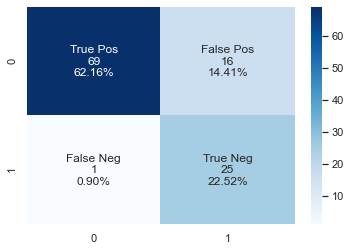

Scores for fold 1:
loss of 0.3669774306787027
accuracy of 0.8468468189239502
precision of 0.6097561120986938
recall of 0.9615384340286255
auc of 0.9730768799781799
true_positives of 25.0
true_negatives of 69.0
false_positives of 16.0
In training:
Class 0: 76.89%
Class 1: 23.11%
In test:
Class 0: 77.27%
Class 1: 22.73%
------------------------------------------------------------------------

Training for fold 2 ...
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 743 samples, validate on 248 samples
Epoch 1/10
743/743 [==============================] - 5s 7ms/sample - loss: 0.4285 - accuracy: 0.8304 - precision: 0.6122 - recall: 0.7059 - auc: 0.8956 - true_positives: 120.0000 - true_negatives: 497.0000 - false_positives: 76.0000 - false_negatives: 50.0000 - val_loss: 0.4810 - val_accuracy: 0.8387 - val_precision: 0.5960 - val_recall: 1.0000 - val_auc: 0.9576 - val_true_positives: 59.0000 - val_true_negatives: 149.0000 - val_false_positives: 40.0000 - val_false_negatives: 0.000

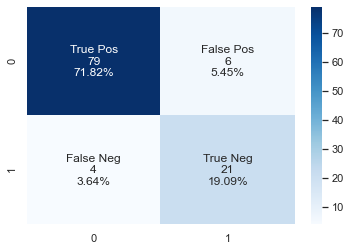

Scores for fold 2:
loss of 0.20232351950623773
accuracy of 0.9090909361839294
precision of 0.7777777910232544
recall of 0.8399999737739563
auc of 0.9696469902992249
true_positives of 21.0
true_negatives of 79.0
false_positives of 6.0
In training:
Class 0: 76.89%
Class 1: 23.11%
In test:
Class 0: 77.27%
Class 1: 22.73%
------------------------------------------------------------------------

Training for fold 3 ...
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 743 samples, validate on 248 samples
Epoch 1/10
743/743 [==============================] - 4s 6ms/sample - loss: 0.5284 - accuracy: 0.6514 - precision: 0.3912 - recall: 0.9412 - auc: 0.8686 - true_positives: 160.0000 - true_negatives: 324.0000 - false_positives: 249.0000 - false_negatives: 10.0000 - val_loss: 0.4736 - val_accuracy: 0.8347 - val_precision: 0.6250 - val_recall: 0.7627 - val_auc: 0.9179 - val_true_positives: 45.0000 - val_true_negatives: 162.0000 - val_false_positives: 27.0000 - val_false_negatives: 14.0

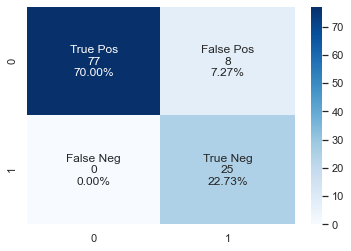

Scores for fold 3:
loss of 0.222285611521114
accuracy of 0.9272727370262146
precision of 0.7575757503509521
recall of 1.0
auc of 0.9818823337554932
true_positives of 25.0
true_negatives of 77.0
false_positives of 8.0
In training:
Class 0: 76.89%
Class 1: 23.11%
In test:
Class 0: 77.27%
Class 1: 22.73%
------------------------------------------------------------------------

Training for fold 4 ...
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 743 samples, validate on 248 samples
Epoch 1/10
743/743 [==============================] - 6s 9ms/sample - loss: 0.5810 - accuracy: 0.7873 - precision: 0.5909 - recall: 0.2294 - auc: 0.7904 - true_positives: 39.0000 - true_negatives: 546.0000 - false_positives: 27.0000 - false_negatives: 131.0000 - val_loss: 0.3335 - val_accuracy: 0.8710 - val_precision: 0.6849 - val_recall: 0.8475 - val_auc: 0.9399 - val_true_positives: 50.0000 - val_true_negatives: 166.0000 - val_false_positives: 23.0000 - val_false_negatives: 9.0000
Epoch 2/10
743/

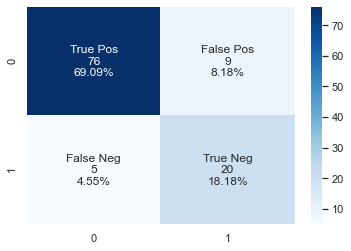

Scores for fold 4:
loss of 0.2924236124212092
accuracy of 0.8727272748947144
precision of 0.6896551847457886
recall of 0.800000011920929
auc of 0.945411741733551
true_positives of 20.0
true_negatives of 76.0
false_positives of 9.0
In training:
Class 0: 76.89%
Class 1: 23.11%
In test:
Class 0: 77.27%
Class 1: 22.73%
------------------------------------------------------------------------

Training for fold 5 ...
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 743 samples, validate on 248 samples
Epoch 1/10
743/743 [==============================] - 8s 11ms/sample - loss: 0.5770 - accuracy: 0.5962 - precision: 0.3529 - recall: 0.9176 - auc: 0.8447 - true_positives: 156.0000 - true_negatives: 287.0000 - false_positives: 286.0000 - false_negatives: 14.0000 - val_loss: 0.4368 - val_accuracy: 0.8024 - val_precision: 0.5532 - val_recall: 0.8814 - val_auc: 0.9223 - val_true_positives: 52.0000 - val_true_negatives: 147.0000 - val_false_positives: 42.0000 - val_false_negatives: 7.0000

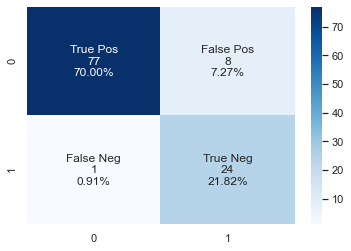

Scores for fold 5:
loss of 0.20206432830203663
accuracy of 0.918181836605072
precision of 0.75
recall of 0.9599999785423279
auc of 0.9903529286384583
true_positives of 24.0
true_negatives of 77.0
false_positives of 8.0
In training:
Class 0: 76.89%
Class 1: 23.11%
In test:
Class 0: 77.27%
Class 1: 22.73%
------------------------------------------------------------------------

Training for fold 6 ...
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 743 samples, validate on 248 samples
Epoch 1/10
743/743 [==============================] - 5s 7ms/sample - loss: 0.5785 - accuracy: 0.4590 - precision: 0.2951 - recall: 0.9824 - auc: 0.8531 - true_positives: 167.0000 - true_negatives: 174.0000 - false_positives: 399.0000 - false_negatives: 3.0000 - val_loss: 0.5213 - val_accuracy: 0.8669 - val_precision: 0.6970 - val_recall: 0.7797 - val_auc: 0.9435 - val_true_positives: 46.0000 - val_true_negatives: 169.0000 - val_false_positives: 20.0000 - val_false_negatives: 13.0000
Epoch 2/10
7

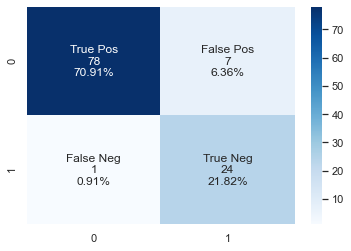

Scores for fold 6:
loss of 0.1808226165446368
accuracy of 0.9272727370262146
precision of 0.774193525314331
recall of 0.9599999785423279
auc of 0.9825882315635681
true_positives of 24.0
true_negatives of 78.0
false_positives of 7.0
In training:
Class 0: 76.89%
Class 1: 23.11%
In test:
Class 0: 77.27%
Class 1: 22.73%
------------------------------------------------------------------------

Training for fold 7 ...
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 743 samples, validate on 248 samples
Epoch 1/10
743/743 [==============================] - 6s 8ms/sample - loss: 0.3984 - accuracy: 0.7456 - precision: 0.4715 - recall: 0.9235 - auc: 0.9089 - true_positives: 157.0000 - true_negatives: 397.0000 - false_positives: 176.0000 - false_negatives: 13.0000 - val_loss: 0.1971 - val_accuracy: 0.9274 - val_precision: 0.7887 - val_recall: 0.9492 - val_auc: 0.9684 - val_true_positives: 56.0000 - val_true_negatives: 174.0000 - val_false_positives: 15.0000 - val_false_negatives: 3.0000

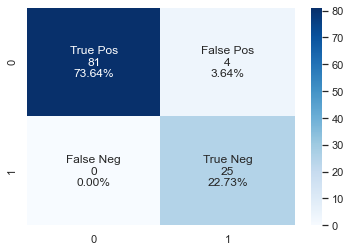

Scores for fold 7:
loss of 0.10208377499472011
accuracy of 0.9636363387107849
precision of 0.8620689511299133
recall of 1.0
auc of 0.9905882477760315
true_positives of 25.0
true_negatives of 81.0
false_positives of 4.0
In training:
Class 0: 76.99%
Class 1: 23.01%
In test:
Class 0: 76.36%
Class 1: 23.64%
------------------------------------------------------------------------

Training for fold 8 ...
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 743 samples, validate on 248 samples
Epoch 1/10
743/743 [==============================] - 6s 8ms/sample - loss: 0.5671 - accuracy: 0.4361 - precision: 0.2713 - recall: 0.9503 - auc: 0.8778 - true_positives: 153.0000 - true_negatives: 171.0000 - false_positives: 411.0000 - false_negatives: 8.0000 - val_loss: 0.4484 - val_accuracy: 0.7823 - val_precision: 0.5537 - val_recall: 1.0000 - val_auc: 0.9383 - val_true_positives: 67.0000 - val_true_negatives: 127.0000 - val_false_positives: 54.0000 - val_false_negatives: 0.0000e+00
Epoch 2/1

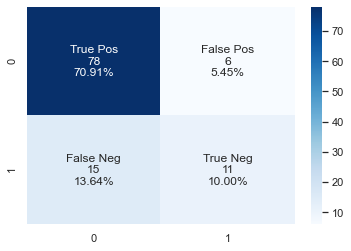

Scores for fold 8:
loss of 0.4217113370245153
accuracy of 0.8090909123420715
precision of 0.6470588445663452
recall of 0.42307692766189575
auc of 0.8484431505203247
true_positives of 11.0
true_negatives of 78.0
false_positives of 6.0
In training:
Class 0: 76.99%
Class 1: 23.01%
In test:
Class 0: 76.36%
Class 1: 23.64%
------------------------------------------------------------------------

Training for fold 9 ...
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 743 samples, validate on 248 samples
Epoch 1/10
743/743 [==============================] - 5s 7ms/sample - loss: 0.5861 - accuracy: 0.4334 - precision: 0.2727 - recall: 0.9689 - auc: 0.8633 - true_positives: 156.0000 - true_negatives: 166.0000 - false_positives: 416.0000 - false_negatives: 5.0000 - val_loss: 0.7241 - val_accuracy: 0.8468 - val_precision: 0.6835 - val_recall: 0.8060 - val_auc: 0.8806 - val_true_positives: 54.0000 - val_true_negatives: 156.0000 - val_false_positives: 25.0000 - val_false_negatives: 13.00

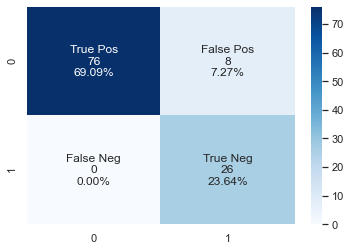

Scores for fold 9:
loss of 0.17668989273634825
accuracy of 0.9272727370262146
precision of 0.7647058963775635
recall of 1.0
auc of 0.9828296303749084
true_positives of 26.0
true_negatives of 76.0
false_positives of 8.0
In training:
Class 0: 76.99%
Class 1: 23.01%
In test:
Class 0: 76.36%
Class 1: 23.64%
------------------------------------------------------------------------

Training for fold 10 ...
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 743 samples, validate on 248 samples
Epoch 1/10
743/743 [==============================] - 5s 7ms/sample - loss: 0.5190 - accuracy: 0.7093 - precision: 0.4110 - recall: 0.7888 - auc: 0.8337 - true_positives: 127.0000 - true_negatives: 400.0000 - false_positives: 182.0000 - false_negatives: 34.0000 - val_loss: 0.4300 - val_accuracy: 0.7742 - val_precision: 0.5455 - val_recall: 0.9851 - val_auc: 0.9607 - val_true_positives: 66.0000 - val_true_negatives: 126.0000 - val_false_positives: 55.0000 - val_false_negatives: 1.0000
Epoch 2/10


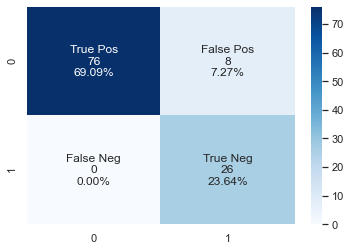

Scores for fold 10:
loss of 0.2072060460394079
accuracy of 0.9272727370262146
precision of 0.7647058963775635
recall of 1.0
auc of 0.9777930974960327
true_positives of 26.0
true_negatives of 76.0
false_positives of 8.0


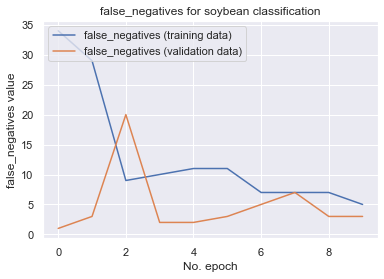

In [19]:
EPOCHS = 10
TRAIN_TEST_SPLIT = 0.25
BATCH_SIZE = 32
acc, prec, rec, auc = train_models(images, labels)

In [23]:
print("Acurácia média: ",np.mean(acc), np.std(acc))
print("Precisão média: ",np.mean(prec), np.std(prec))
print("Recall médio: ",np.mean(rec), np.std(rec))
print("Auc média: ",np.mean(auc), np.std(auc))

Acurácia média:  0.9028665 0.043805677
Precisão média:  0.7397498 0.068747625
Recall médio:  0.8944615 0.17080277
Auc média:  0.96426135 0.040526558


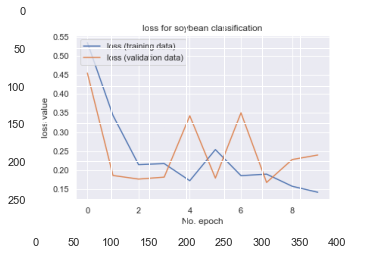

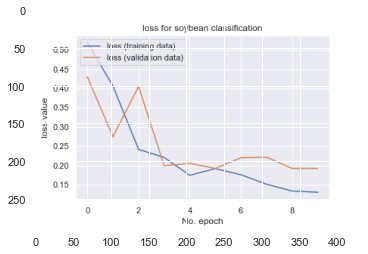

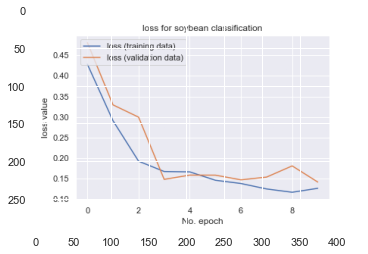

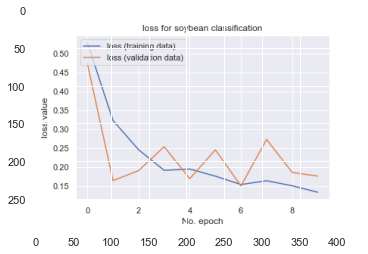

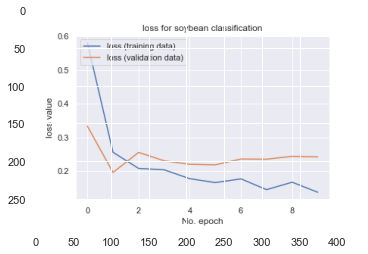

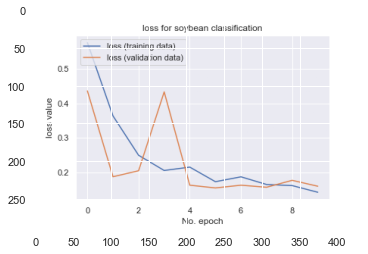

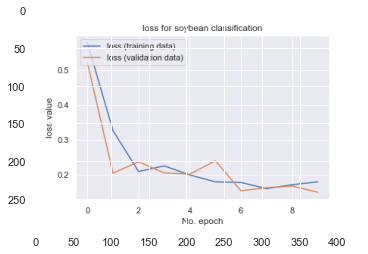

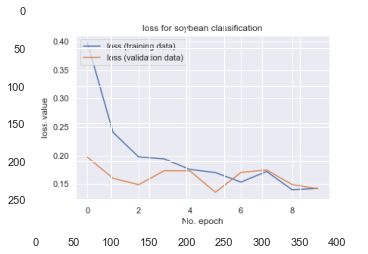

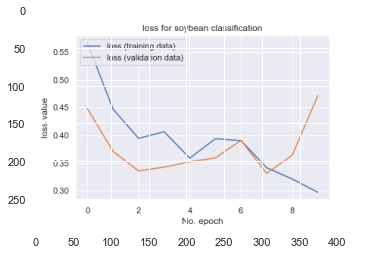

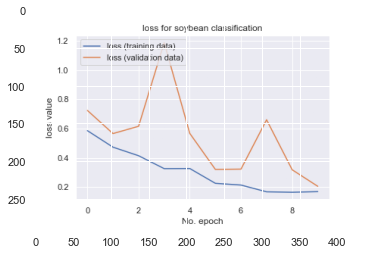

In [24]:
for model in os.listdir("../metricas/classificacao/7_d/tests-binary/adhoc/models"):
    metric_path = os.path.join("../metricas/classificacao/7_d/tests-binary/adhoc/models", model, "loss.png")
    img = plt.imread(metric_path)
    plt.imshow(img)
    plt.show()